In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import scipy
from scipy.io import loadmat
from IPython.display import HTML

Simulation results are stored in a Matlab file with a `.mat` format. We're interested in finding a lower dimensional decomposition of the vorticity defined as
$$ \boldsymbol \omega = \nabla \times \mathbf u $$
where $\mathbf u$ is the velocity field with two components $\mathbf u = [u, v]$. Let's first plot the vorticity

In [2]:
# Import data

results = loadmat('cyl_flow_data.mat')

m = int(results['m'][0][0])
n = int(results['n'][0][0])
v = results['VALL'][:, 0].reshape((n, m))
u = results['UALL'][:, 0].reshape((n, m))
vort0 = results['VORTALL'][:, 0].reshape((n, m))
tsteps = results['VORTALL'].shape[1]

vall = results['VORTALL'].reshape((n, m, tsteps)).T

In [3]:
vall.shape

(151, 199, 449)

Use `imshow` to plot the vorticity at $t=0$

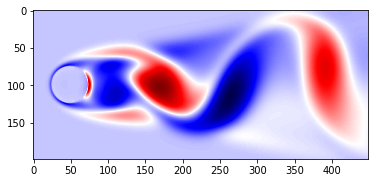

In [4]:
vortmean = np.mean(vall, axis=0)
vc = vall - vortmean

plt.imshow(vc[0, :, :], cmap='seismic')
plt.show()

### Visualize a dynamical system

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(vc[0, :, :], cmap='seismic')

def animate(i):
    im.set_data(vc[i, :, :])
    return [im]

animation = FuncAnimation(fig, animate, frames=range(0, tsteps), interval=20) # interval in ms
plt.close()
HTML(animation.to_jshtml())


In [6]:
# Build data matrix

X = np.zeros((n*m, tsteps))
for i in range(tsteps):
    X[:, i] = vc[i, :, :].flatten('F')

X.shape

(89351, 151)

In [7]:
# Compute SVD
[U, S, V] = np.linalg.svd(X, full_matrices=False)

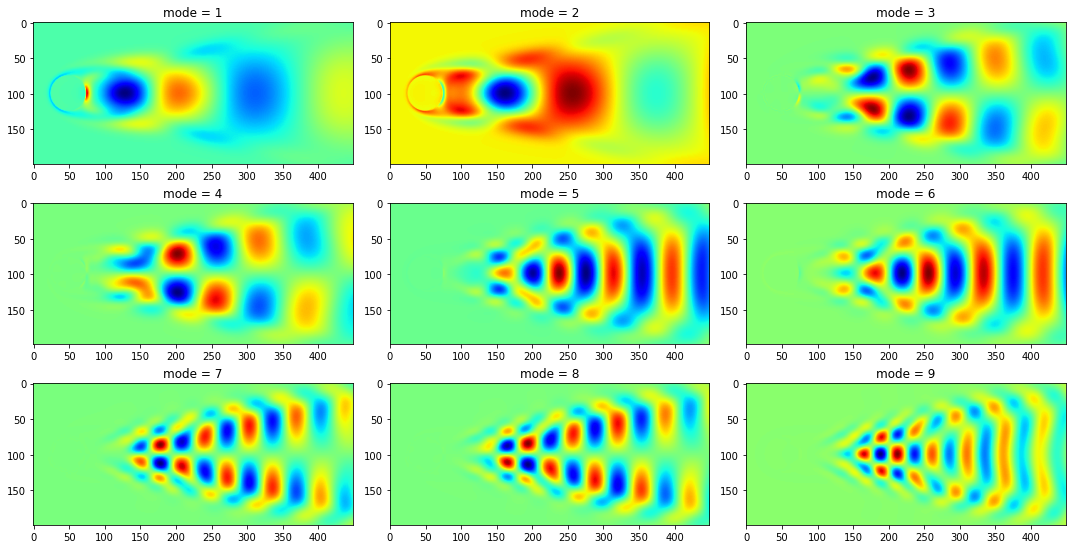

In [8]:
fig = plt.figure(figsize=(15, 10))

for k in range(9):
    uplot = U[:, k].reshape((m, n), order='F')
    ax = fig.add_subplot(4, 3, k+1)
    ax.imshow(uplot, cmap='jet')
    ax.set_title('mode = %d'%(k+1))
plt.tight_layout()
plt.show()

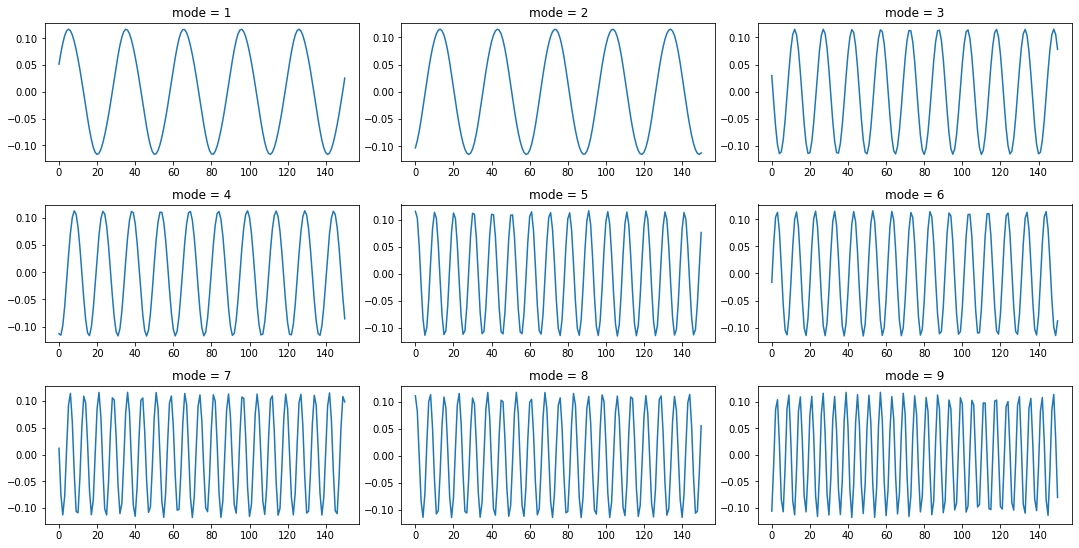

In [9]:
fig = plt.figure(figsize=(15, 10))

for k in range(9):
    uplot = V[k, :]
    ax = fig.add_subplot(4, 3, k+1)
    ax.plot(uplot)
    ax.set_title('mode = %d'%(k+1))
plt.tight_layout()
plt.show()

POD/SVD is a linear dimensionality reduction technique. Its modes are interpretable as the optimal basis for reconstructing the dynamics/data. However, if the data is nonlinear, POD fails to separate it into orthogonal modes. In that case, a nonlinear dimensionality reduction technique is needed. This motivates the use of autoencoders. Check this paper for examples where Autoencoders are better than PCA: https://people.maths.bris.ac.uk/~maxvd/reduce_dim.pdf

Whether nonlinear dimensionality reduction is required in fluids depends on the problem. Let's apply it to the flow around a cylinder problem.

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [52]:
class network(nn.Module):
    def __init__(self, input_size=1000, output_size=3, layer_sizes=[500, 200, 100]):
        super(network, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.layer_sizes = layer_sizes
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(self.input_size, self.layer_sizes[0]))
        for i in range(len(self.layer_sizes)-1):
            self.layers.append(nn.Linear(self.layer_sizes[i], self.layer_sizes[i+1]))
        self.layers.append(nn.Linear(self.layer_sizes[-1], self.output_size))

    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            if i != len(self.layers)-1:
                x = F.elu(x)
        return x

input_size = X.shape[1]
output_size = 10 
layer_ratios = [0.5, 0.2]
layer_sizes = [int(input_size * ratio) for ratio in layer_ratios]
print(layer_sizes)

encoder = network(input_size=input_size, output_size=output_size, layer_sizes=layer_sizes)
decoder = network(input_size=output_size, output_size=input_size, layer_sizes=layer_sizes[::-1])
model = nn.Sequential(encoder, decoder)


[75, 30]


In [64]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

print(X.shape)
Xt = torch.tensor(X, dtype=torch.float32)
trainset = TensorDataset(Xt, Xt)
trainset_dl = DataLoader(trainset, batch_size=100, shuffle=True)


(89351, 151)


Define optimizer and loss function

Define Training loop (per epoch):

    1. Forward pass (predict) 
    2. Compute loss 
    3. Backward pass (compute gradients), and zero gradients
    4. Update weights (optimization step) 

This page goes through pytorch's syntax step-by-step

In [59]:
# Define optimizer and loss function
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [63]:
# Define training loop
def train_loop(model, loss_fn, optim, xtrain, epochs=100):
    for i in range(epochs):
        for xt, xt in xtrain:
            y_pred = model(xt)
            loss = loss_fn(y_pred, xt)
            loss.backward()
            optim.step()
            optim.zero_grad()
            
            # if j%100 == 0:
        print('Epoch: {}, Loss: {}'.format(i, loss))

# Train model
train_loop(model, loss_fn, optim, trainset_dl, epochs=20)

Epoch: 0, Loss: 0.000386919011361897
Epoch: 1, Loss: 0.00033209912362508476
Epoch: 2, Loss: 0.0009814782533794641
Epoch: 3, Loss: 0.00046994053991511464
Epoch: 4, Loss: 0.0003022958117071539
Epoch: 5, Loss: 0.00026350977714173496
Epoch: 6, Loss: 0.0002889219322241843
Epoch: 7, Loss: 0.00020242543541826308
Epoch: 8, Loss: 0.0003393682709429413
Epoch: 9, Loss: 0.00015823841386009008
Epoch: 10, Loss: 0.00017889625451061875
Epoch: 11, Loss: 0.00018075363186653703
Epoch: 12, Loss: 0.0003007487393915653
Epoch: 13, Loss: 0.00016591986059211195
Epoch: 14, Loss: 0.00014410268340725452
Epoch: 15, Loss: 0.00010024535731645301
Epoch: 16, Loss: 0.0001257405965588987
Epoch: 17, Loss: 0.0001115736595238559
Epoch: 18, Loss: 0.00022943901421967894
Epoch: 19, Loss: 0.00012131893163314089


tensor(0.0001, grad_fn=<MseLossBackward0>)


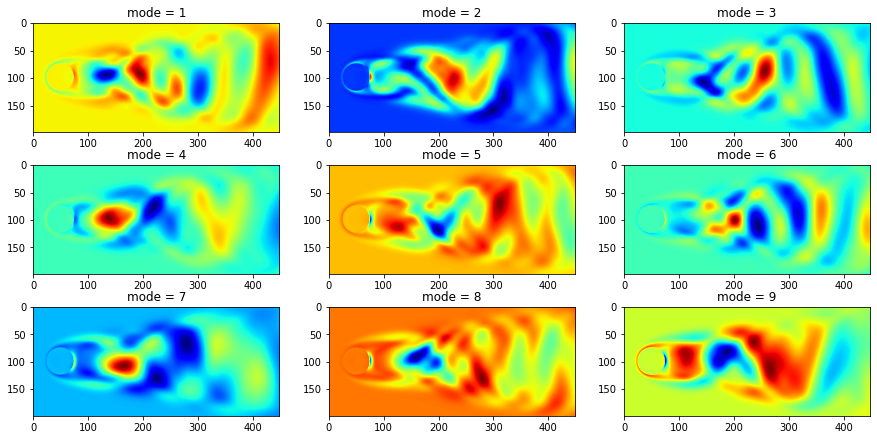

In [65]:
# Plot results
print(loss_fn(model(Xt), Xt))

# Plot results
fig = plt.figure(figsize=(15, 10))

for k in range(9):
    uplot = model[0](Xt).detach().numpy()[:, k].reshape((m, n), order='F')
    ax = fig.add_subplot(4, 3, k+1)
    ax.imshow(uplot, cmap='jet')
    ax.set_title('mode = %d'%(k+1))
